In [ ]:
!pip install torchdyn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 2.9 MB/s 
     |████████████████████████████████| 708 kB 9.2 MB/s 
     |████████████████████████████████| 59 kB 6.7 MB/s 
     |████████████████████████████████| 193 kB 65.2 MB/s 
     |████████████████████████████████| 1.6 MB 35.1 MB/s 
     |████████████████████████████████| 5.9 MB 29.6 MB/s 
     |████████████████████████████████| 529 kB 48.1 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=2e9944ae2250c78c246c0d3fb83152c9e28a698eaac57cc1fb22c580f7c75c05
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not

In [ ]:
#@title score functions
import math
import numpy as np

from functools import reduce
from scipy.spatial.distance import cdist
import numba


@numba.njit(parallel=True,fastmath=True)
def my_cdist(r,y, output,dist='euclidean'):
    """   
    Fast computation of pairwise distances between data points in r and y matrices.
    Stores the distances in the output array.
    Available distances: 'euclidean' and 'seucledian'
    
    Parameters
    ----------
    r : NxM array
        First set of N points of dimension M.
    y : N2xM array
        Second set of N2 points of dimension M.
    output : NxN2 array
        Placeholder for storing the output of the computed distances.
    dist : type of distance, optional
        Select 'euclidian' or 'sqeuclidian' for Euclidian or squared Euclidian
        distances. The default is 'euclidean'.

    Returns
    -------
    None. (The result is stored in place in the provided array "output").

    """
    N, M = r.shape
    N2, M2 = y.shape
    #assert( M == M2, 'The two inpus have different second dimention! Input should be N1xM and N2xM')
    if dist == 'euclidean':
        for i in numba.prange(N):
            for j in numba.prange(N2):
                tmp = 0.0
                for k in range(M):
                    tmp += (r[i, k] - y[j, k])**2            
                output[i,j] = math.sqrt(tmp)
    elif dist == 'sqeuclidean':
        for i in numba.prange(N):
            for j in numba.prange(N2):
                tmp = 0.0
                for k in range(M):
                    tmp += (r[i, k] - y[j, k])**2            
                output[i,j] = tmp   
    elif dist == 'l1':
        for i in numba.prange(N):
            for j in numba.prange(N2):
                tmp = 0.0
                for k in range(M):
                    tmp += (r[i, k] - y[j, k])**2          
                output[i,j] = math.sqrt(tmp)   
    return 0


def score_function_multid_seperate_all_dims(X,Z,func_out=False, C=0.001,kern ='RBF',l=1):
    """
    Sparse kernel based estimation of multidimensional logarithmic gradient of empirical density represented 
    by samples X for all dimensions simultaneously. 
    
    - When `funct_out == False`: computes grad-log at the sample points.
    - When `funct_out == True`: return a function for the grad log to be employed for interpolation/estimation of grad log 
                               in the vicinity of the samples.
    
    Parameters
    -----------
            X: N x dim array,
               N samples from the density (N x dim), where dim>=2 the 
               dimensionality of the system.
            Z: M x dim array,
              inducing points points (M x dim).
            func_out : Boolean, 
                      True returns function, 
                      if False returns grad-log-p evaluated on samples X.                    
            l: float or array-like,
               lengthscale of rbf kernel (scalar or vector of size dim).
            C: float,
              weighting constant 
              (leave it at default value to avoid unreasonable contraction 
              of deterministic trajectories).
            kern: string,
                options:
                    - 'RBF': radial basis function/Gaussian kernel  
                    - 'periodic': periodic, not functional yet.           
           
    Returns
    -------
        res1: array with logarithmic gradient of the density  N_s x dim or function 
                 that accepts as inputs 2dimensional arrays of dimension (K x dim), where K>=1.
    
    """
    
    if kern=='RBF':
        """
        #@numba.njit(parallel=True,fastmath=True)
        def Knumba(x,y,l,res,multil=False): #version of kernel in the numba form when the call already includes the output matrix
            if multil:                                        
                for ii in range(len(l)): 
                    tempi = np.zeros((x[:,ii].size, y[:,ii].size ), dtype=np.float64)
                    ##puts into tempi the cdist result                    
                    my_cdist(x[:,ii:ii+1], y[:,ii:ii+1],tempi,'sqeuclidean')
                    
                    res = np.multiply(res,np.exp(-tempi/(2*l[ii]*l[ii])))                    
                    
            else:
                tempi = np.zeros((x.shape[0], y.shape[0] ), dtype=np.float64)                
                my_cdist(x, y,tempi,'sqeuclidean') #this sets into the array tempi the cdist result
                res = np.exp(-tempi/(2*l*l))
            return 0
        """
        
        def K(x,y,l,multil=False):
            if multil:   
                res = np.ones((x.shape[0],y.shape[0]))                
                for ii in range(len(l)): 
                    tempi = np.zeros((x[:,ii].size, y[:,ii].size ))
                    ##puts into tempi the cdist result
                    my_cdist(x[:,ii].reshape(-1,1), y[:,ii].reshape(-1,1),tempi,'sqeuclidean')
                    res = np.multiply(res,np.exp(-tempi/(2*l[ii]*l[ii])))                    
                    
                return res
            else:
                tempi = np.zeros((x.shape[0], y.shape[0] ))
                
                my_cdist(x, y,tempi,'sqeuclidean') #this sets into the array tempi the cdist result
                return np.exp(-tempi/(2*l*l))
            
        
        def grdx_K_all(x,y,l,multil=False): #gradient with respect to the 1st argument - only which_dim
            N,dim = x.shape    
            M,_ = y.shape
            diffs = x[:,None]-y                         
            redifs = np.zeros((1*N,M,dim))
            for ii in range(dim):          
            
                if multil:
                    redifs[:,:,ii] = np.multiply(diffs[:,:,ii],K(x,y,l,True))/(l[ii]*l[ii])   
                else:
                    redifs[:,:,ii] = np.multiply(diffs[:,:,ii],K(x,y,l))/(l*l)            
            return redifs
            
        
        def grdx_K(x,y,l,which_dim=1,multil=False): #gradient with respect to the 1st argument - only which_dim
            #_,dim = x.shape 
            #M,_ = y.shape
            diffs = x[:,None]-y                         
            #redifs = np.zeros((1*N,M))
            ii = which_dim -1            
            if multil:
                redifs = np.multiply(diffs[:,:,ii],K(x,y,l,True))/(l[ii]*l[ii])  
                
            else:
                redifs = np.multiply(diffs[:,:,ii],K(x,y,l))/(l*l)            
            return redifs
     
        
            #############################################################################
    elif kern=='periodic': ###############################################################################################
        ### DO NOT USE "periodic" yet!!!!!!!
      ###periodic kernel
        ## K(x,y) = exp(  -2 * sin^2( pi*| x-y  |/ (2*pi)  )   /l^2)
        
        ## Kx(x,y) = (K(x,y)* (x - y) cos(abs(x - y)/2) sin(abs(x - y)/2))/(l^2 abs(x - y))
        ## -(2 K(x,y) π (x - y) sin((2 π abs(x - y))/per))/(l^2 s abs(x - y))
      #per = 2*np.pi ##period of the kernel
      
      def K(x,y,l,multil=False):
        
        if multil:       
          res = np.ones((x.shape[0],y.shape[0]))                
          for ii in range(len(l)): 
              #tempi = np.zeros((x[:,ii].size, y[:,ii].size ))
              ##puts into tempi the cdist result
              #my_cdist(x[:,ii].reshape(-1,1), y[:,ii].reshape(-1,1),tempi, 'l1')              
              #res = np.multiply(res, np.exp(- 2* (np.sin(tempi/ 2 )**2) /(l[ii]*l[ii])) )
              res = np.multiply(res, np.exp(- 2* (np.sin(cdist(x[:,ii].reshape(-1,1), y[:,ii].reshape(-1,1),'minkowski', p=1)/ 2 )**2) /(l[ii]*l[ii])) )
          return -res
        else:
            #tempi = np.zeros((x.shape[0], y.shape[0] ))
            ##puts into tempi the cdist result
            #my_cdist(x, y, tempi,'l1')
            #res = np.exp(-2* ( np.sin( tempi / 2 )**2 ) /(l*l) )
            res = np.exp(-2* ( np.sin( cdist(x, y,'minkowski', p=1) / 2 )**2 ) /(l*l) )
            return res
        
      def grdx_K(x,y,l,which_dim=1,multil=False): #gradient with respect to the 1st argument - only which_dim
          #N,dim = x.shape            
          diffs = x[:,None]-y             
          #redifs = np.zeros((1*N,N))
          ii = which_dim -1          
          if multil:
              redifs = np.divide( np.multiply( np.multiply( np.multiply( -2*K(x,y,l,True),diffs[:,:,ii] ),np.sin( np.abs(diffs[:,:,ii]) / 2) ) ,np.cos( np.abs(diffs[:,:,ii])  / 2) ) , (l[ii]*l[ii]* np.abs(diffs[:,:,ii]))  ) 
          else:
              redifs = np.divide( np.multiply( np.multiply( np.multiply( -2*diffs[:,:,ii],np.sin( np.abs(diffs[:,:,ii]) / 2) ) ,K(x,y,l) ),np.cos( np.abs(diffs[:,:,ii]) / 2) ) ,(l*l* np.abs(diffs[:,:,ii])) )           
          return -redifs

    #dim = X.shape[1]

    if isinstance(l, (list, tuple, np.ndarray)):
       multil = True
       ### for different lengthscales for each dimension 
       #K_xz =  np.ones((X.shape[0],Z.shape[0]), dtype=np.float64) 
       #Knumba(X,Z,l,K_xz,multil=True) 
       
       #Ks =  np.ones((Z.shape[0],Z.shape[0]), dtype=np.float64) 
       #Knumba(Z,Z,l,Ks,multil=True) 
       K_xz = K(X,Z,l,multil=True) 
       Ks = K(Z,Z,l,multil=True)    
       
       #print(Z.shape)
       Ksinv = np.linalg.inv(Ks+ 1e-3 * np.eye(Z.shape[0]))
       A = K_xz.T @ K_xz    
              
       gradx_K = -grdx_K_all(X,Z,l,multil=True) #-
       #gradxK = np.zeros((X.shape[0],Z.shape[0],dim))
       #for ii in range(dim):
           #gradxK[:,:,ii] = -grdx_K(X,Z,l,multil=True,which_dim=ii+1)
       
       #np.testing.assert_allclose(gradxK, gradx_K) 
    else:
        multil = False
        
        K_xz = K(X,Z,l,multil=False) 
        
        Ks = K(Z,Z,l,multil=False)    
        
        Ksinv = np.linalg.inv(Ks+ 1e-3 * np.eye(Z.shape[0]))
        A = K_xz.T @ K_xz    
        
        gradx_K = -grdx_K_all(X,Z,l,multil=False)   #shape: (N,M,dim)
    sumgradx_K = np.sum(gradx_K ,axis=0) ##last axis will have the gradient for each dimension ### shape (M, dim)
    
    if func_out==False: #if output wanted is evaluation at data points
        
        # res1 = np.zeros((N, dim))    
        # ### evaluatiion at data points
        # for di in range(dim):
        #     res1[:,di] = -K_xz @ np.linalg.inv( C*np.eye(Z.shape[0], Z.shape[0]) + Ksinv @ A + 1e-3 * np.eye(Z.shape[0]))@ Ksinv@sumgradx_K[:,di]
        
        
        res1 = -K_xz @ np.linalg.inv( C*np.eye(Z.shape[0], Z.shape[0]) + Ksinv @ A + 1e-3 * np.eye(Z.shape[0]))@ Ksinv@sumgradx_K        
        
        #res1 = np.einsum('ik,kj->ij', -K_xz @ np.linalg.inv( C*np.eye(Z.shape[0], Z.shape[0]) + Ksinv @ A + 1e-3 * np.eye(Z.shape[0]))@ Ksinv, sumgradx_K)
        
        
    else:           
        #### for function output 
        if multil:      
            if kern=='RBF':      
                K_sz = lambda x: reduce(np.multiply, [ np.exp(-cdist(x[:,iii].reshape(-1,1), Z[:,iii].reshape(-1,1),'sqeuclidean')/(2*l[iii]*l[iii])) for iii in range(x.shape[1]) ])        
                
            elif kern=='periodic':
                K_sz = lambda x: np.multiply(np.exp(-2*(np.sin( cdist(x[:,0].reshape(-1,1), Z[:,0].reshape(-1,1), 'minkowski', p=2)/(l[0]*l[0])))),np.exp(-2*(np.sin( cdist(x[:,1].reshape(-1,1), Z[:,1].reshape(-1,1),'sqeuclidean')/(l[1]*l[1])))))
            
        else:
            if kern=='RBF':
                K_sz = lambda x: np.exp(-cdist(x, Z,'sqeuclidean')/(2*l*l))
            elif kern=='periodic':
                K_sz = lambda x: np.exp(-2* ( np.sin( cdist(x, Z,'minkowski', p=1) / 2 )**2 ) /(l*l) )
            

        res1 = lambda x: K_sz(x) @ ( -np.linalg.inv( C*np.eye(Z.shape[0], Z.shape[0]) + Ksinv @ A + 1e-3 * np.eye(Z.shape[0])) ) @ Ksinv@sumgradx_K
        
            
        #np.testing.assert_allclose(res2, res1)
    
    return res1   ### shape out N x dim



In [ ]:
#@title plotting specifications
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 'figure'
plt.rcParams['savefig.facecolor'] = (1,1,1,0)
plt.rcParams['savefig.bbox'] = 'standard'#"tight"
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'sans-serif'     # not available in Colab
plt.rcParams['font.sans-serif'] = 'Verdana'#'Helvetica'  # not available in Colab
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.linewidth'] = 2
plt.rc('axes',edgecolor='#4f4949')
plt.rcParams['figure.frameon'] = False
#plt.rcParams['figure.subplot.hspace'] = 0.05
#plt.rcParams['figure.subplot.wspace'] = 0.05
#plt.rcParams['figure.subplot.left'] = 0.4
#plt.rcParams['figure.subplot.right'] = 0.5            
plt.rcParams['text.usetex'] = False


In [ ]:




def plot_the_score(scores, low_b=[-1,-1], high_b=[1,1],num_points=20):
    x1 = np.linspace(low_b[0], high_b[0], num_points)
    x2 = np.linspace(low_b[1], high_b[1], num_points)
    x, y = np.meshgrid(x1, x2)
    grid = np.stack([x.flatten(), y.flatten()], axis=1)
    
    sc = scores(grid)
    plt.quiver(grid[:, 0], grid[:, 1], sc[:, 0], sc[:, 1], angles='uv',
               color='#C84374', width=0.0032,linewidths=0.55, edgecolors='#C96D8F')
    




In [ ]:
from torchdyn.datasets import ToyDataset

##score function multiple two dim Gaussian
# The dataset has about 16k samples
n_samples = 1 << 13

# That will be spread across 6 Gaussians on a plave. 
n_gaussians = 1

# Torchdyn has a helper funciton to generate the dataset.
X1, yn1 = ToyDataset().generate(n_samples // n_gaussians, 
                              'diffeqml', 
                              n_gaussians=n_gaussians, 
                              std_gaussians=0.5, 
                              radius=4, dim=2)


X2, yn2 = ToyDataset().generate(n_samples // n_gaussians*3, 
                              'gaussians', 
                              n_gaussians=n_gaussians*3, 
                              std_gaussians=0.5, 
                              radius=4, dim=2)



# Z-score the generated dataset.
X1 = ((X1 - X1.mean())/X1.std()).detach().numpy()
X2 = ((X2 - X2.mean())/X2.std()).detach().numpy()


#################################################################################
M1 =100
bnds = np.zeros((2, 2))
for ii in range(2):
    bnds[ii] = [np.min(X1[:,ii]), np.max(X1[:,ii])]
sum_bnds = np.sum(bnds) 
Sxx1 = np.array([np.random.uniform(low=bnd[0], high=bnd[1], size=(M1)) for bnd in bnds])


bnds = np.zeros((2, 2))
for ii in range(2):
    bnds[ii] = [np.min(X2[:,ii]), np.max(X2[:,ii])]
sum_bnds = np.sum(bnds) 
Sxx2 = np.array([np.random.uniform(low=bnd[0], high=bnd[1], size=(M1)) for bnd in bnds])



sx1 = score_function_multid_seperate_all_dims(X1, Sxx1.T, True, C=0.001,
                                              l=np.ones(2))
sx2 = score_function_multid_seperate_all_dims(X2, Sxx2.T, True,C=0.001,
                                              l=np.ones(2))



TypeError: ignored

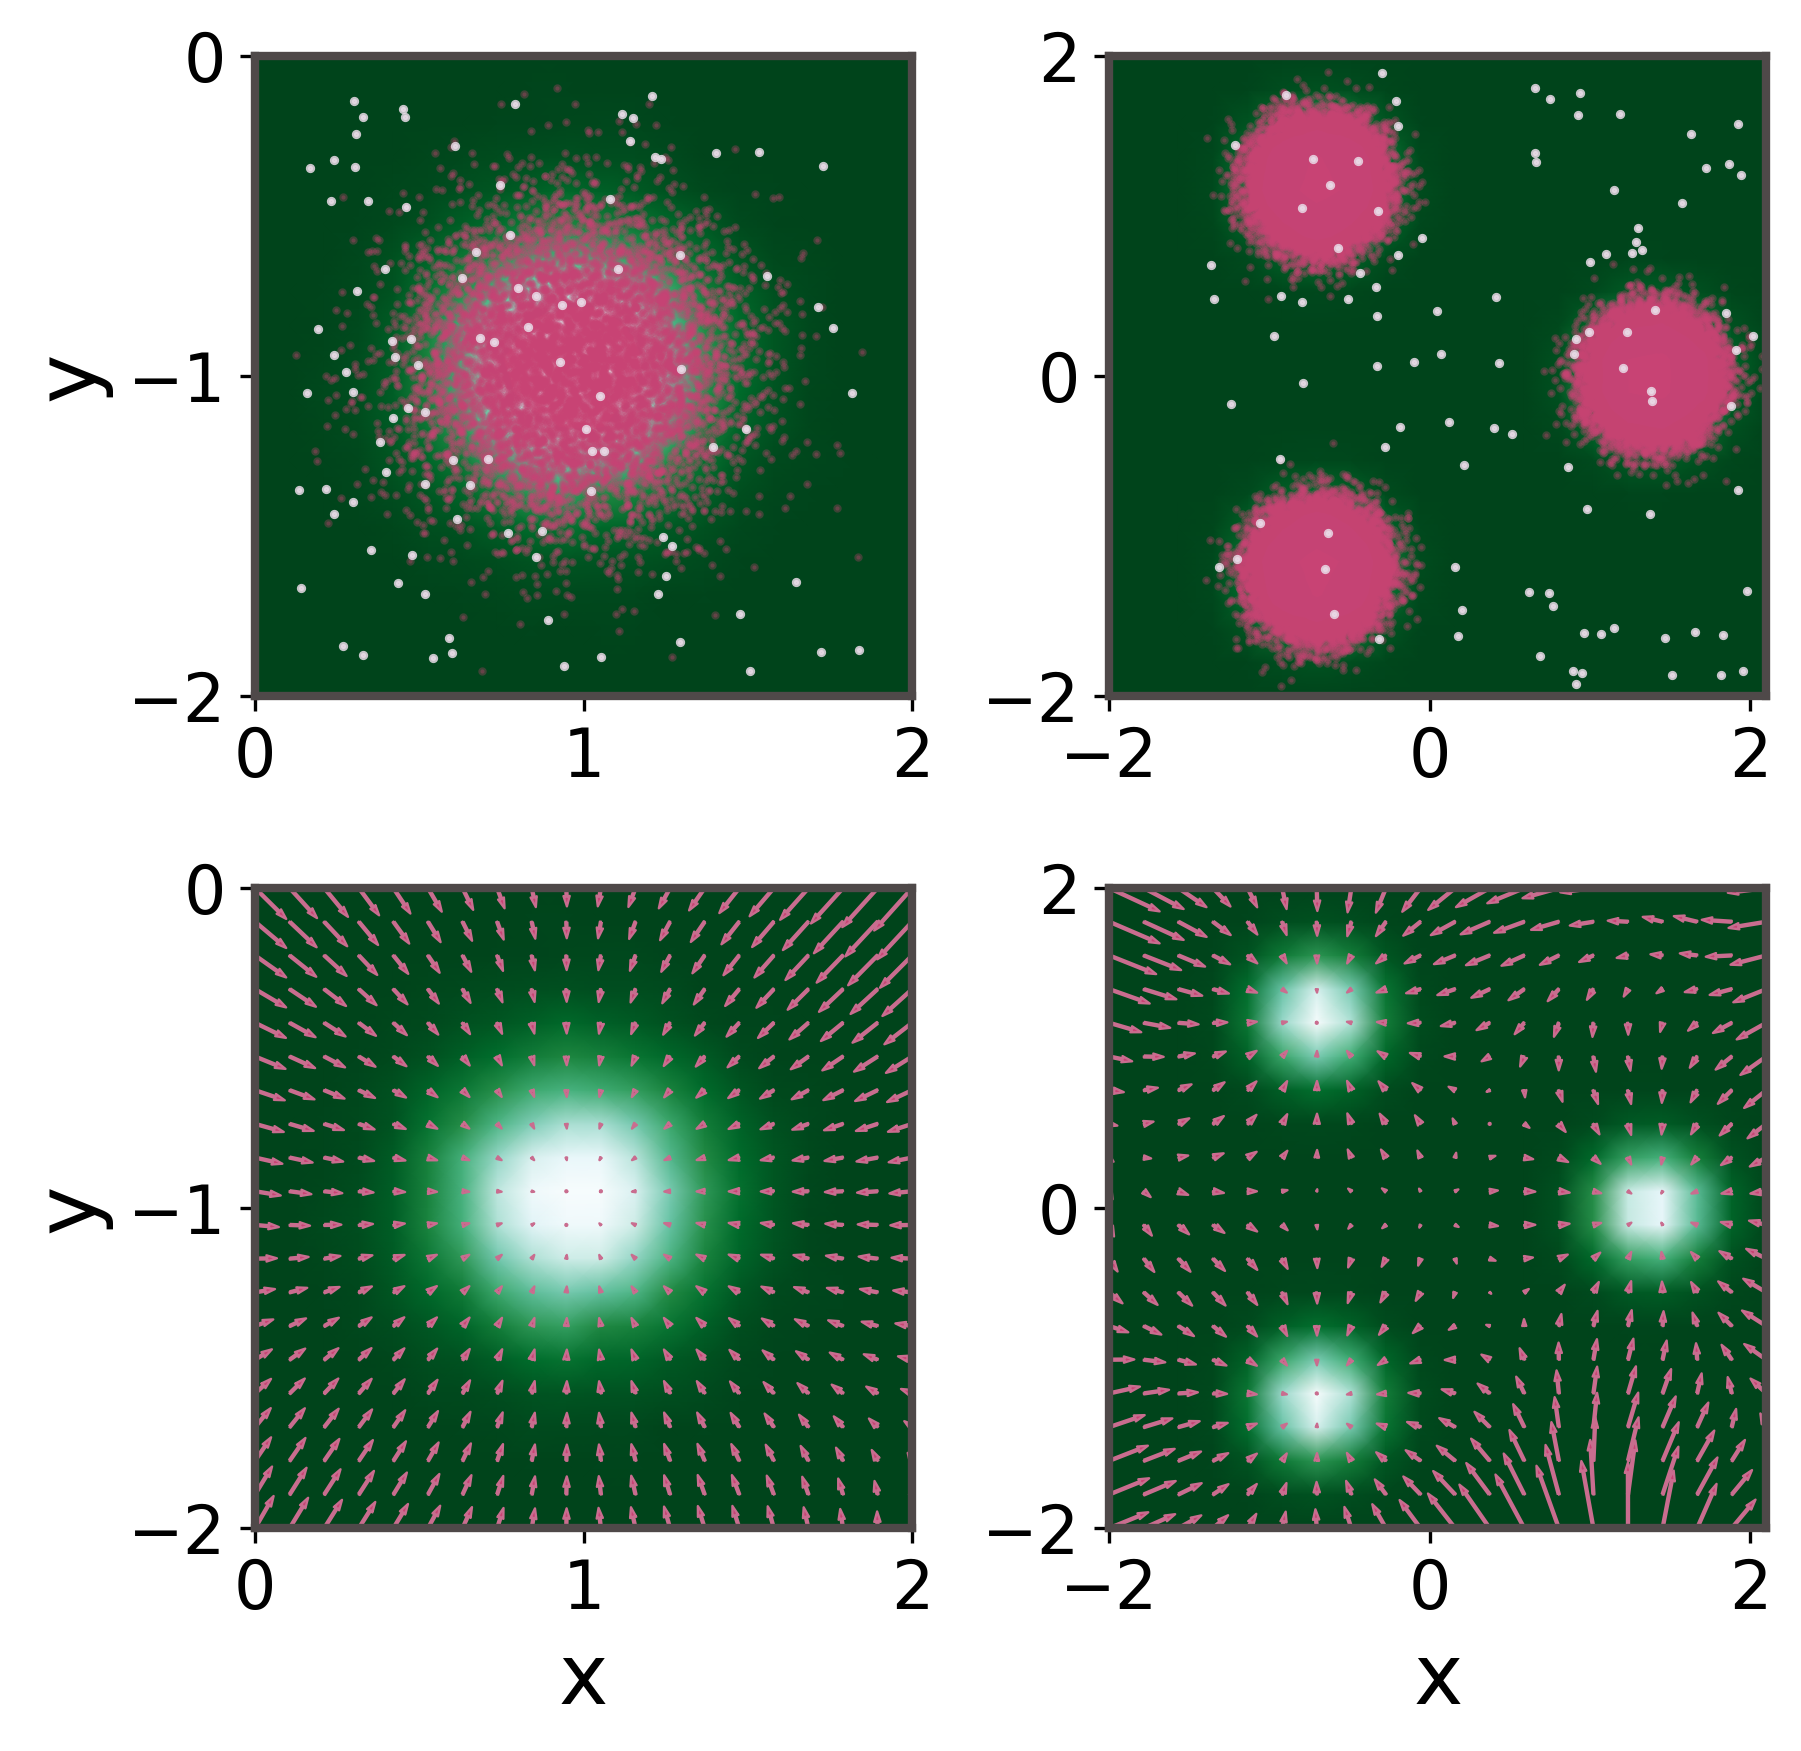

In [ ]:
from scipy.stats import kde
nbins = 20
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k1 = kde.gaussian_kde(X1.T)
xi1, yi1 = np.mgrid[0:2:nbins*1j, -2:0:nbins*1j]
zi1 = k1(np.vstack([xi1.flatten(), yi1.flatten()]))
# Let's look what we have
plt.figure(figsize=(6.5, 6.5))
plt.subplot(2,2,1)
plt.pcolormesh(xi1, yi1, zi1.reshape(xi1.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
plt.scatter(X1[:,0], X1[:,1], alpha=0.3, s=1., c='#C84374')
plt.scatter(Sxx1[0], Sxx1[1], alpha=0.85, s=1.5, c='#E9DBE7')
plt.ylabel('y', fontsize=20)
plt.yticks([-2, -1, 0])
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k2 = kde.gaussian_kde(X2.T)
xi2, yi2 = np.mgrid[-2:2.1:nbins*1j, -2:2:nbins*1j]
zi2 = k2(np.vstack([xi2.flatten(), yi2.flatten()]))

plt.subplot(2,2,2)
plt.pcolormesh(xi2, yi2, zi2.reshape(xi2.shape), shading='gouraud', cmap=plt.cm.BuGn_r, alpha=1)
plt.scatter(X2[:,0], X2[:,1], alpha=0.3, s=1., c='#C84374')
plt.scatter(Sxx2[0], Sxx2[1], alpha=0.85, s=1.5, c='#E9DBE7')
plt.yticks([-2, 0, 2])

plt.subplot(2,2,3)
plt.pcolormesh(xi1, yi1, zi1.reshape(xi1.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
plot_the_score(sx1,  [0,-2], [2,0] )
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.yticks([-2, -1, 0])
plt.subplot(2,2,4)
plt.pcolormesh(xi2, yi2, zi2.reshape(xi2.shape), shading='gouraud', cmap=plt.cm.BuGn_r, alpha=1)
plot_the_score(sx2,  [-2,-2], [2.1,2])
plt.xlabel('x', fontsize=20)
plt.yticks([-2, 0, 2])
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.savefig("score_2d_examples_N_%d_M_%d.png"%(n_samples,M1), bbox_inches='tight',dpi=300, 
            transparent='False',  facecolor='white')
plt.savefig("score_2d_examples_N_%d_M_%d.pdf"%(n_samples,M1), bbox_inches='tight',dpi=300, 
            transparent='False',  facecolor='white')


In [ ]:
from torchdyn.datasets import ToyDataset
import numpy as np
from matplotlib import pyplot as plt
##score function multiple two dim Gaussian
# The dataset has about 16k samples
n_samples = 1 << 14

# That will be spread across 6 Gaussians on a plave. 
n_gaussians = 1

# Torchdyn has a helper funciton to generate the dataset.
X1, yn1 = ToyDataset().generate(int(n_samples /10), 
                              'diffeqml', noise=0.1)


X2, yn2 = ToyDataset().generate(n_samples, 
                              'diffeqml', noise=0.1)



# Z-score the generated dataset.
X1 = ((X1 - X1.mean())/X1.std()).detach().numpy()
X2 = ((X2 - X2.mean())/X2.std()).detach().numpy()


#################################################################################
M1 =100
bnds = np.zeros((2, 2))
for ii in range(2):
    bnds[ii] = [np.min(X1[:,ii]), np.max(X1[:,ii])]
sum_bnds = np.sum(bnds) 
Sxx1 = np.array([np.random.uniform(low=bnd[0], high=bnd[1], size=(M1)) for bnd in bnds])


bnds = np.zeros((2, 2))
for ii in range(2):
    bnds[ii] = [np.min(X2[:,ii]), np.max(X2[:,ii])]
sum_bnds = np.sum(bnds) 
Sxx2 = np.array([np.random.uniform(low=bnd[0], high=bnd[1], size=(M1)) for bnd in bnds])



sx1 = score_function_multid_seperate_all_dims(X1, Sxx1.T, True, C=0.001,
                                              l=np.ones(2))
sx2 = score_function_multid_seperate_all_dims(X2, Sxx2.T, True,C=0.001,
                                              l=np.ones(2))



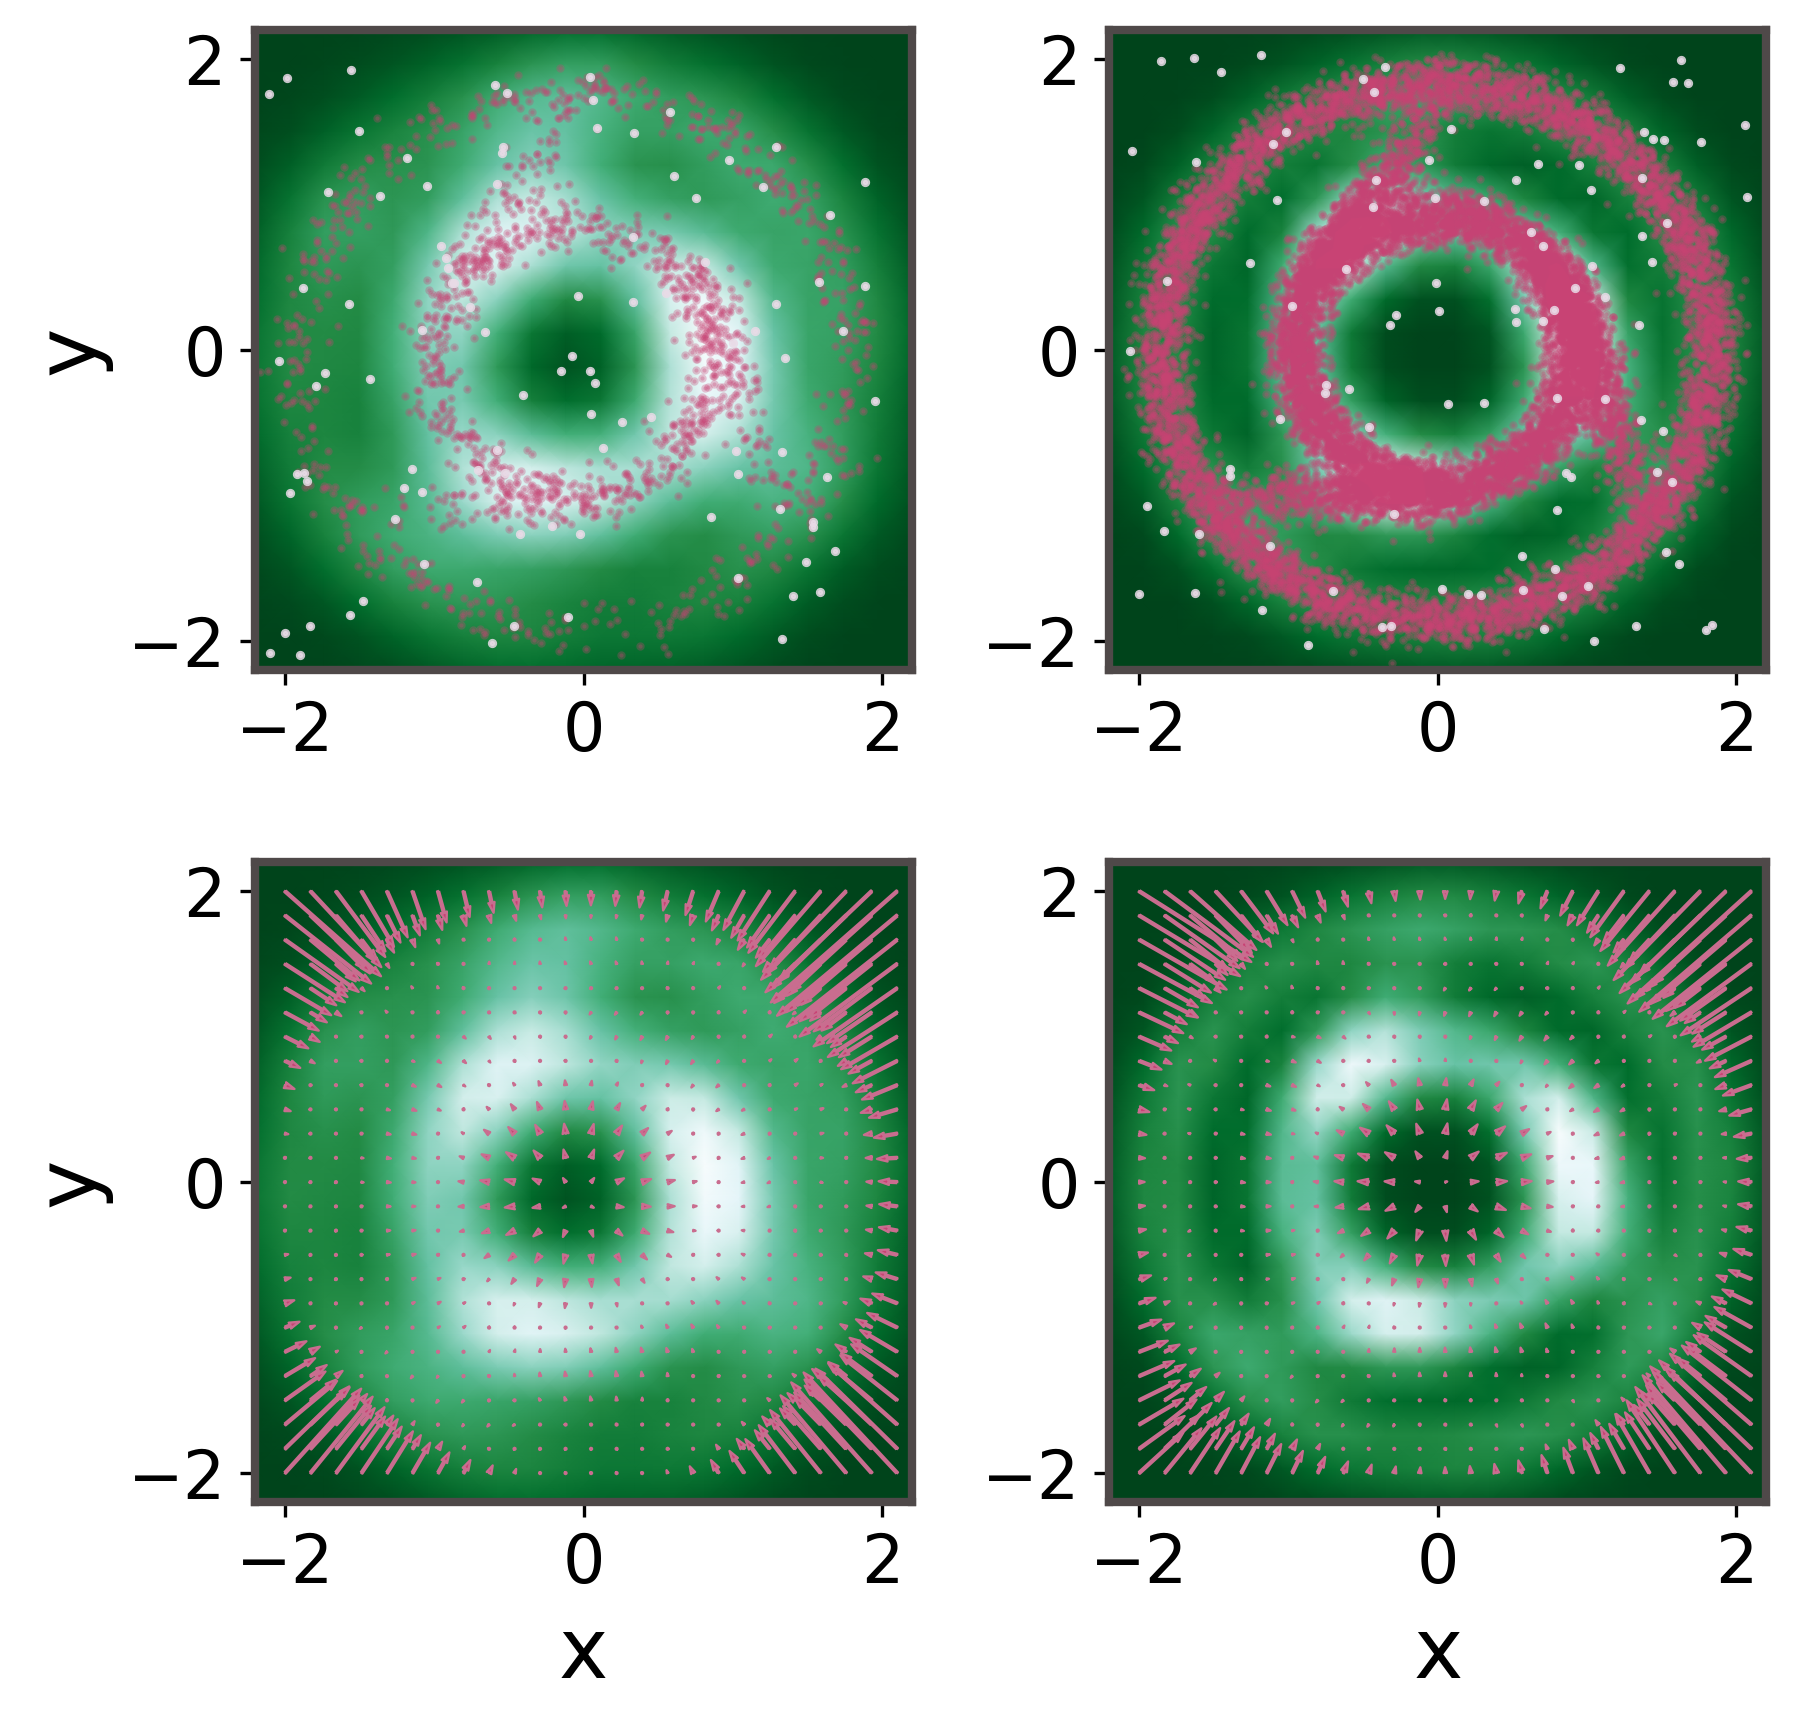

In [ ]:
from scipy.stats import kde
nbins = 20
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k1 = kde.gaussian_kde(X1.T)
xi1, yi1 = np.mgrid[-2.2:2.2:nbins*1j, -2.2:2.2:nbins*1j]
zi1 = k1(np.vstack([xi1.flatten(), yi1.flatten()]))
# Let's look what we have
plt.figure(figsize=(6.5, 6.5))
plt.subplot(2,2,1)
plt.pcolormesh(xi1, yi1, zi1.reshape(xi1.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
plt.scatter(X1[:,0], X1[:,1], alpha=0.3, s=1., c='#C84374')
plt.scatter(Sxx1[0], Sxx1[1], alpha=0.85, s=1.5, c='#E9DBE7')
plt.ylabel('y', fontsize=20)
plt.yticks([-2, 0, 2])
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k2 = kde.gaussian_kde(X2.T)
xi2, yi2 = np.mgrid[-2.2:2.2:nbins*1j, -2.2:2.2:nbins*1j]
zi2 = k2(np.vstack([xi2.flatten(), yi2.flatten()]))

plt.subplot(2,2,2)
plt.pcolormesh(xi2, yi2, zi2.reshape(xi2.shape), shading='gouraud', cmap=plt.cm.BuGn_r, alpha=1)
plt.scatter(X2[:,0], X2[:,1], alpha=0.3, s=1., c='#C84374')
plt.scatter(Sxx2[0], Sxx2[1], alpha=0.85, s=1.5, c='#E9DBE7')
plt.yticks([-2, 0, 2])

plt.subplot(2,2,3)
plt.pcolormesh(xi1, yi1, zi1.reshape(xi1.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
plot_the_score(sx1,   [-2,-2], [2.1,2], num_points=25 )
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.yticks([-2, 0, 2])
plt.subplot(2,2,4)
plt.pcolormesh(xi2, yi2, zi2.reshape(xi2.shape), shading='gouraud', cmap=plt.cm.BuGn_r, alpha=1)
plot_the_score(sx2,  [-2,-2], [2.1,2],num_points=25)
plt.xlabel('x', fontsize=20)
plt.yticks([-2, 0, 2])
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.savefig("score_2d_circleexamples_N_%d_M_%d.png"%(n_samples,M1), bbox_inches='tight',dpi=300, 
            transparent='False',  facecolor='white')
plt.savefig("score_2d_circleexamples_N_%d_M_%d.pdf"%(n_samples,M1), bbox_inches='tight',dpi=300, 
            transparent='False',  facecolor='white')
